# Gibbs Sampling: A Quick Introduction

Gibbs sampling is a Markov chain Monte Carlo (MCMC) algorithm designed to sample from a joint distribution by iteratively sampling each variable from its conditional distribution given the others. For a two-dimensional random vector (x, y) with joint density p(x, y), Gibbs alternates between:

- Sample x ~ p(x | y)
- Sample y ~ p(y | x)

Under mild conditions (irreducibility, aperiodicity), the resulting Markov chain has p(x, y) as its stationary distribution. Gibbs is especially convenient when conditional distributions are standard and easy to sample (e.g., Gaussian conditionals in a multivariate normal). This notebook demonstrates a 2D Gaussian example, analyzes convergence with ArviZ (trace plots, ESS, R-hat), and shows how to save/load results for reproducible workflows.

In [121]:
import sys
import warnings
from typing import Optional, Tuple

import arviz as az
import matplotlib.pyplot as plt
import numpy as np

from mc_lab.gibbs_sampler_2d import GibbsSampler2D

# Fixed seed for reproducibility
GLOBAL_RANDOM_SEED = 42
np.random.seed(GLOBAL_RANDOM_SEED)


warnings.filterwarnings("ignore")

# Set ArviZ style
az.style.use("arviz-whitegrid")

In [122]:
# Configuration (edit here to change the experiment)

CONFIG = {
    "true_mean": np.array([2.0, -1.0]),
    "true_cov": np.array([[2.0, 0.8], [0.8, 1.5]]),
    "n_samples": 2000,
    "n_chains": 1,
    "burn_in": 0,
    "thin": 1,
    "random_seed": 42,
    "progressbar": True,
    "show_advanced_arviz": False,
    "var_names": ("x", "y"),
    "output_file": "gibbs_samples.nc",
}

CONFIG

{'true_mean': array([ 2., -1.]),
 'true_cov': array([[2. , 0.8],
        [0.8, 1.5]]),
 'n_samples': 2000,
 'n_chains': 1,
 'burn_in': 0,
 'thin': 1,
 'random_seed': 42,
 'progressbar': True,
 'show_advanced_arviz': False,
 'var_names': ('x', 'y'),
 'output_file': 'gibbs_samples.nc'}

In [123]:
def create_mvn_gibbs_sampler(
    mean: np.ndarray, cov: np.ndarray, var_names: Tuple[str, str] = ("x", "y")
) -> GibbsSampler2D:
    """
    Create a Gibbs sampler for a 2D multivariate normal distribution.

    Parameters:
    -----------
    mean : np.ndarray
        Mean vector [mu_x, mu_y]
    cov : np.ndarray
        2x2 covariance matrix
    var_names : tuple of str
        Names for the variables

    Returns:
    --------
    sampler : GibbsSampler2D
        Configured Gibbs sampler for the MVN distribution
    """
    mu_x, mu_y = mean
    sigma_xx, sigma_yy = cov[0, 0], cov[1, 1]
    sigma_xy = cov[0, 1]

    # Conditional samplers
    def sample_x_given_y(y):
        conditional_mean = mu_x + (sigma_xy / sigma_yy) * (y - mu_y)
        conditional_var = sigma_xx - (sigma_xy**2 / sigma_yy)
        return np.random.normal(conditional_mean, np.sqrt(conditional_var))
        # return gamma.rvs(3, scale=1 / (y * y + 4))

    def sample_y_given_x(x):
        conditional_mean = mu_y + (sigma_xy / sigma_xx) * (x - mu_x)
        conditional_var = sigma_yy - (sigma_xy**2 / sigma_xx)
        return np.random.normal(conditional_mean, np.sqrt(conditional_var))
        # return norm.rvs(1 / (1 + x), scale=1.0 / np.sqrt(2 * (x + 1)))

    # Log probability function for diagnostics
    def log_prob(x, y):
        state = np.array([x, y])
        diff = state - mean
        return -0.5 * (
            diff @ np.linalg.inv(cov) @ diff + np.log(2 * np.pi * np.linalg.det(cov))
        )

    return GibbsSampler2D(sample_x_given_y, sample_y_given_x, None, var_names)

In [124]:
import seaborn as sns


def demonstrate_arviz_diagnostics(
    idata: az.InferenceData,
    true_mean: Optional[np.ndarray] = None,
    true_cov: Optional[np.ndarray] = None,
):
    """
    Demonstrate various ArviZ diagnostic plots and statistics.

    Parameters:
    -----------
    idata : arviz.InferenceData
        InferenceData object from Gibbs sampling
    true_mean : np.ndarray, optional
        True mean for comparison
    true_cov : np.ndarray, optional
        True covariance for comparison
    """
    print("=" * 80)
    print("ArviZ Diagnostic Analysis")
    print("=" * 80)

    # 1. Summary statistics
    print("\n1. Summary Statistics:")
    print("-" * 40)
    summary = az.summary(idata)
    print(summary)

    # 2. Trace plot (the main request!)
    print("\n2. Creating Trace Plot...")
    az.plot_trace(
        idata,
        figsize=(12, 6),
        combined=True,
        compact=True,
        backend_kwargs={"constrained_layout": True},
    )
    plt.suptitle("Trace Plot: Gibbs Sampler Results", fontsize=14, y=1.02)
    plt.show()

    # 3. Posterior plot with reference values
    print("\n3. Creating Posterior Plot...")
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Get variable names
    var_names = list(idata.posterior.data_vars)

    for idx, var in enumerate(var_names):
        az.plot_posterior(
            idata,
            var_names=[var],
            ax=axes[idx],
            ref_val=true_mean[idx] if true_mean is not None else None,
            kind="hist",
            bins=30,
        )
    plt.suptitle("Posterior Distributions", fontsize=14)
    plt.tight_layout()
    plt.show()

    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    # 4. Pair plot
    print("\n4. Creating Pair Plot...")
    az.plot_pair(
        idata,
        figsize=(8, 8),
        kind=["scatter", "hexbin"],
        marginals=True,
        point_estimate="mean",
        gridsize=100,
        # kde_kwargs={
        #     # "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
        #     "contourf_kwargs": {"cmap": cmap},
        # },
        # gridsize=50, bins='log', cmap='inferno'
        hexbin_kwargs={"cmap": cmap, "bins": "log"},
        backend_kwargs={"constrained_layout": True},
    )
    plt.suptitle("Pair Plot: Joint and Marginal Distributions", fontsize=14, y=1.02)
    plt.show()

    # 5. Autocorrelation plot
    print("\n5. Creating Autocorrelation Plot...")
    az.plot_autocorr(
        idata,
        figsize=(12, 4),
        combined=True,
        backend_kwargs={"constrained_layout": True},
    )
    plt.suptitle("Autocorrelation Functions", fontsize=14)
    plt.show()

    # # 6. Energy plot (if we have log probabilities)
    # if "lp" in idata.sample_stats:
    #     print("\n6. Creating Energy Plot...")
    #     az.plot_energy(idata, figsize=(10, 4))
    #     plt.show()

    # 7. Rank plots for convergence
    print("\n7. Creating Rank Plot...")
    az.plot_rank(idata, figsize=(12, 4), backend_kwargs={"constrained_layout": True})
    plt.suptitle("Rank Plots (for convergence diagnosis)", fontsize=14)
    plt.show()

    # 8. ESS (Effective Sample Size)
    print("\n8. Effective Sample Size:")
    print("-" * 40)
    ess = az.ess(idata)
    for var in var_names:
        print(f"{var}: {ess[var].values:.0f}")

    # Create ESS plot
    az.plot_ess(
        idata,
        kind="evolution",
        figsize=(12, 4),
        backend_kwargs={"constrained_layout": True},
    )
    plt.suptitle("ESS Evolution", fontsize=14)
    plt.show()

    # 9. R-hat (Convergence diagnostic)
    print("\n9. R-hat Statistics (should be < 1.01 for convergence):")
    print("-" * 40)
    rhat = az.rhat(idata)
    for var in var_names:
        print(f"{var}: {rhat[var].values:.4f}")

    # 10. MCSE (Monte Carlo Standard Error)
    print("\n10. Monte Carlo Standard Error:")
    print("-" * 40)
    mcse = az.mcse(idata)
    for var in var_names:
        print(f"{var}: {mcse[var].values:.4f}")

    # 11. Compare with true values if provided
    if true_mean is not None and true_cov is not None:
        print("\n11. Comparison with True Distribution:")
        print("-" * 40)

        # Extract posterior means and covariance
        posterior_mean = np.array(
            [idata.posterior[var].mean().values for var in var_names]
        )

        samples = np.column_stack(
            [idata.posterior[var].values.flatten() for var in var_names]
        )
        posterior_cov = np.cov(samples.T)

        print(f"True Mean:      {true_mean}")
        print(f"Posterior Mean: {posterior_mean}")
        print(f"Mean Error:     {np.abs(posterior_mean - true_mean)}")

        print("\nTrue Covariance:")
        print(true_cov)
        print("\nPosterior Covariance:")
        print(posterior_cov)
        print(
            f"\nCovariance Frobenius Error: {np.linalg.norm(posterior_cov - true_cov, 'fro'):.4f}"
        )

In [125]:
def advanced_arviz_examples(idata: az.InferenceData):
    """
    Show advanced ArviZ functionality for MCMC diagnostics.
    """
    print("\n" + "=" * 80)
    print("Advanced ArviZ Features")
    print("=" * 80)

    # 1. Forest plot (comparing chains)
    print("\n1. Forest Plot (comparing chains)...")
    az.plot_forest(idata, combined=False, figsize=(10, 6), r_hat=True, ess=True)
    plt.title("Forest Plot: Chain Comparison with R-hat and ESS")
    plt.show()

    # 2. Density comparison across chains
    print("\n2. Density Plot (overlay all chains)...")
    az.plot_density(
        idata,
        figsize=(12, 4),
        hdi_prob=0.95,
        point_estimate="mean",
        backend_kwargs={"constrained_layout": True},
    )
    plt.suptitle("Density Plots with 95% HDI", fontsize=14)
    plt.show()

    # 3. Violin plot
    print("\n3. Violin Plot...")
    az.plot_violin(idata, figsize=(10, 6), sharey=False)
    plt.title("Violin Plot: Distribution Shape Across Chains")
    plt.show()

    # 4. Parallel coordinates plot
    # print("\n4. Parallel Coordinates Plot...")
    # az.plot_parallel(
    #     idata, figsize=(10, 6), backend_kwargs={"constrained_layout": True}
    # )
    # plt.title("Parallel Coordinates: Parameter Relationships")
    # plt.show()

    # 5. KDE plot with quantiles
    print("\n5. KDE Plot with Quantiles...")
    az.plot_kde(
        idata.posterior.x.values.flatten(),
        idata.posterior.y.values.flatten(),
        figsize=(8, 8),
        contour=True,
        fill_last=True,
        quantiles=[0.1, 0.25, 0.5, 0.75, 0.9],
    )
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("2D KDE with Quantile Contours")
    plt.show()

In [126]:
def run_demo(config: dict) -> az.InferenceData:
    """Run the full demo using a config dictionary."""
    # Define the true multivariate normal distribution
    true_mean = config["true_mean"]
    true_cov = config["true_cov"]

    print("=" * 80)
    print("Gibbs Sampler with ArviZ Integration")
    print("=" * 80)
    print("\nTrue Distribution Parameters:")
    print(f"Mean: {true_mean}")
    print(f"Covariance:\n{true_cov}")

    # Create Gibbs sampler for MVN
    print("\nCreating Gibbs sampler for multivariate normal...")
    sampler = create_mvn_gibbs_sampler(
        mean=true_mean, cov=true_cov, var_names=config["var_names"]
    )

    # Run sampling with multiple chains
    print("\nRunning Gibbs sampler with multiple chains...")
    idata = sampler.sample(
        n_samples=config["n_samples"],
        n_chains=config["n_chains"],
        burn_in=config["burn_in"],
        thin=config["thin"],
        random_seed=config["random_seed"],
        progressbar=config["progressbar"],
    )

    print("\nSampling complete!")
    print(f"InferenceData groups: {list(idata.groups())}")
    print(f"Posterior variables: {list(idata.posterior.data_vars)}")
    print(f"Shape: {idata.posterior.x.shape} (chains × draws)")

    # Run comprehensive diagnostics
    demonstrate_arviz_diagnostics(idata, true_mean, true_cov)

    # Show advanced features (optional)
    if config.get("show_advanced_arviz", False):
        advanced_arviz_examples(idata)

    return idata


# Intentionally do not execute run_demo() here to avoid long runs on import.
# Use the cell below to run the demo explicitly with CONFIG.

In [127]:
# Reproducibility and Environment Info
import matplotlib

print(f"Python: {sys.version.split()[0]}")
print(f"NumPy: {np.__version__}")
print(f"ArviZ: {az.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")
print(f"Global RNG seed set to: {GLOBAL_RANDOM_SEED}")

Python: 3.12.11
NumPy: 2.0.2
ArviZ: 0.22.0
Matplotlib: 3.10.0
Global RNG seed set to: 42


Gibbs Sampler with ArviZ Integration

True Distribution Parameters:
Mean: [ 2. -1.]
Covariance:
[[2.  0.8]
 [0.8 1.5]]

Creating Gibbs sampler for multivariate normal...

Running Gibbs sampler with multiple chains...


Chain 1/1: 100%|██████████| 2000/2000 [00:00<00:00, 3217.08it/s, samples=2000]
arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
Chain 1/1: 100%|██████████| 2000/2000 [00:00<00:00, 3217.08it/s, samples=2000]
arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)



Sampling complete!
InferenceData groups: ['posterior']
Posterior variables: ['x', 'y']
Shape: (1, 2000) (chains × draws)
ArviZ Diagnostic Analysis

1. Summary Statistics:
----------------------------------------
    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
x  2.037  1.378  -0.588    4.496      0.041    0.023    1152.0    1548.0   
y -0.955  1.228  -3.300    1.234      0.033    0.020    1383.0    1577.0   

   r_hat  
x    NaN  
y    NaN  

2. Creating Trace Plot...


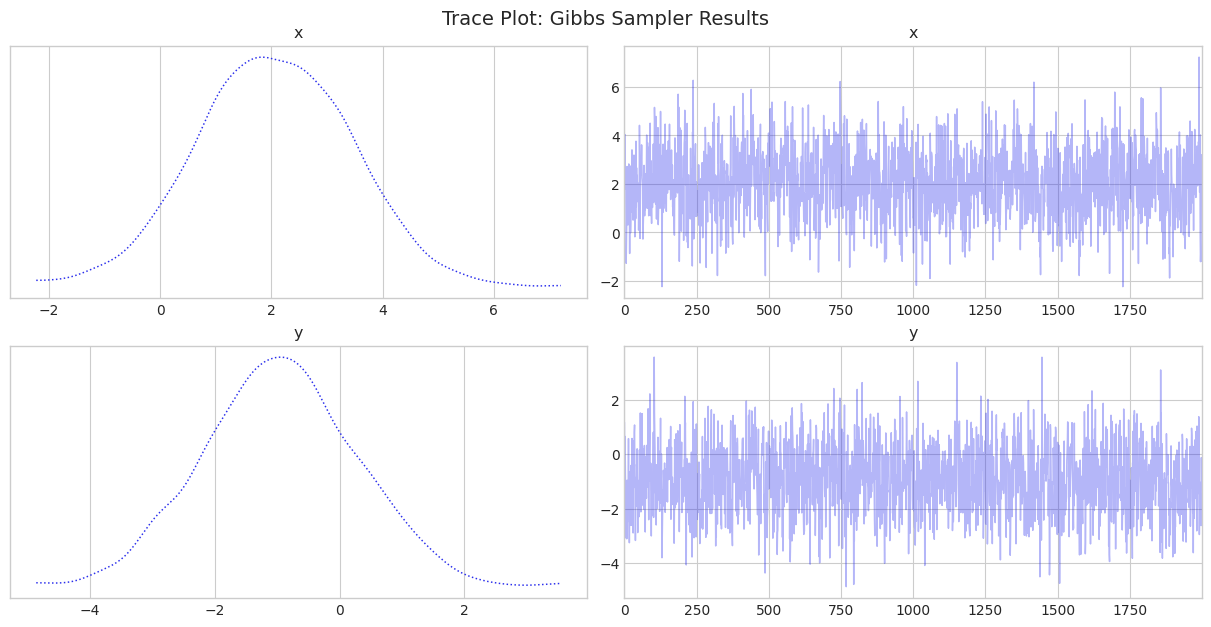


3. Creating Posterior Plot...


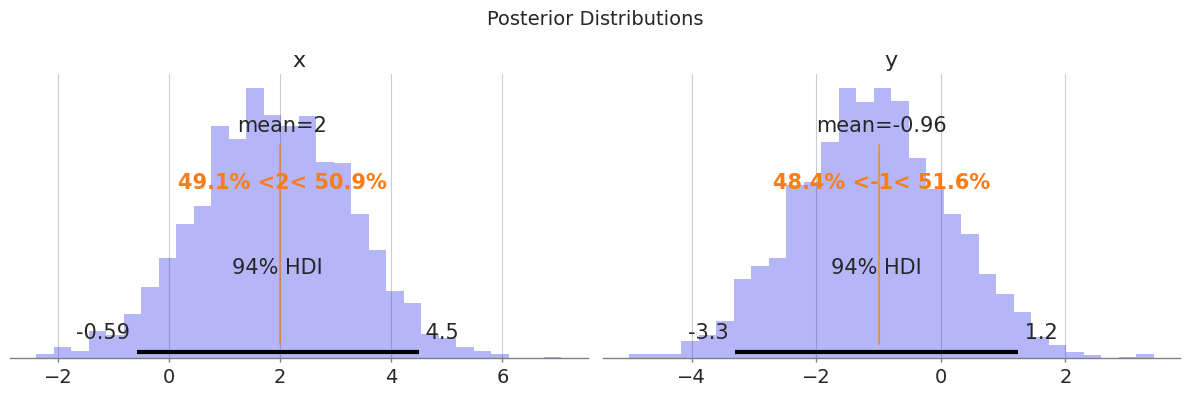


4. Creating Pair Plot...


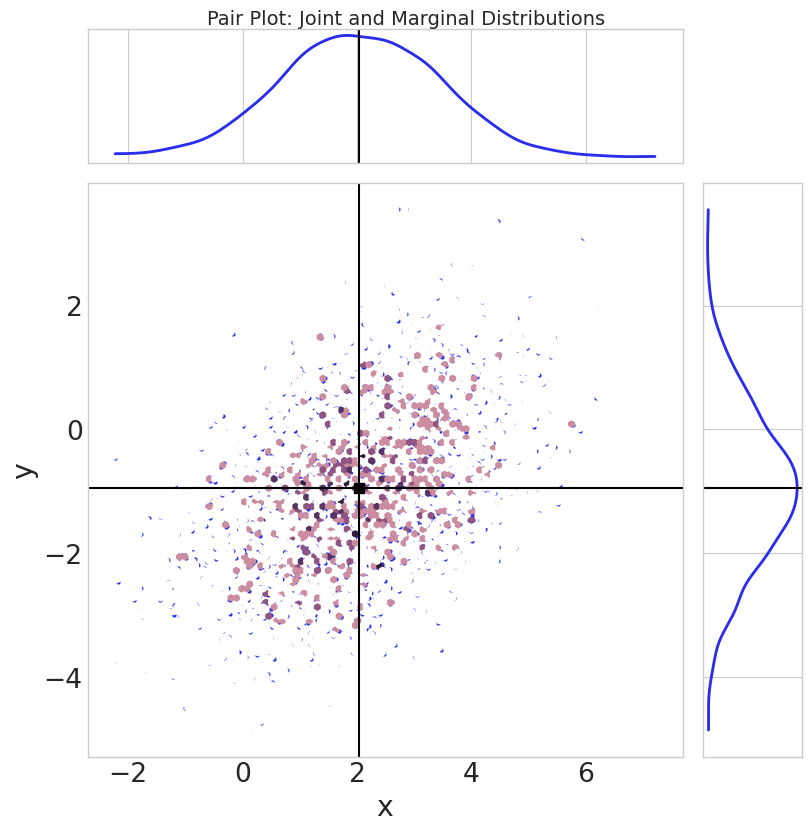


5. Creating Autocorrelation Plot...


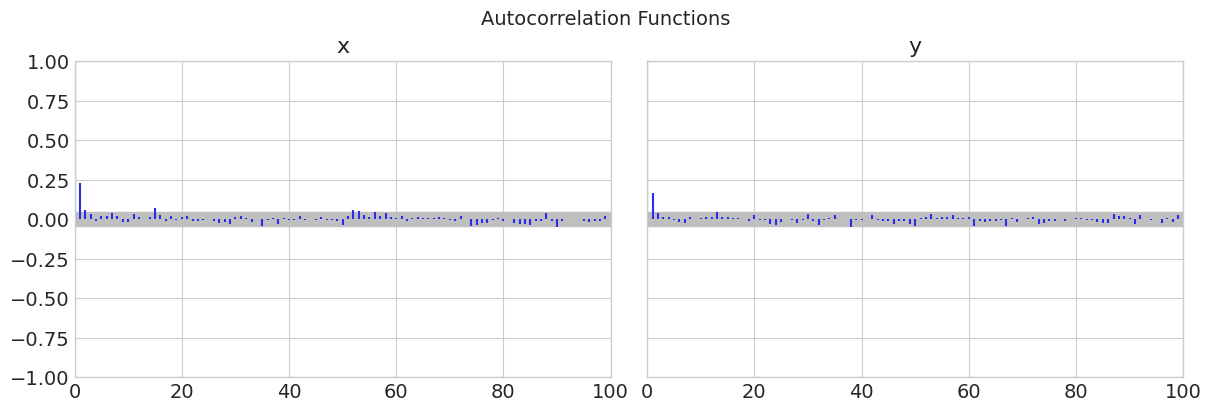


7. Creating Rank Plot...


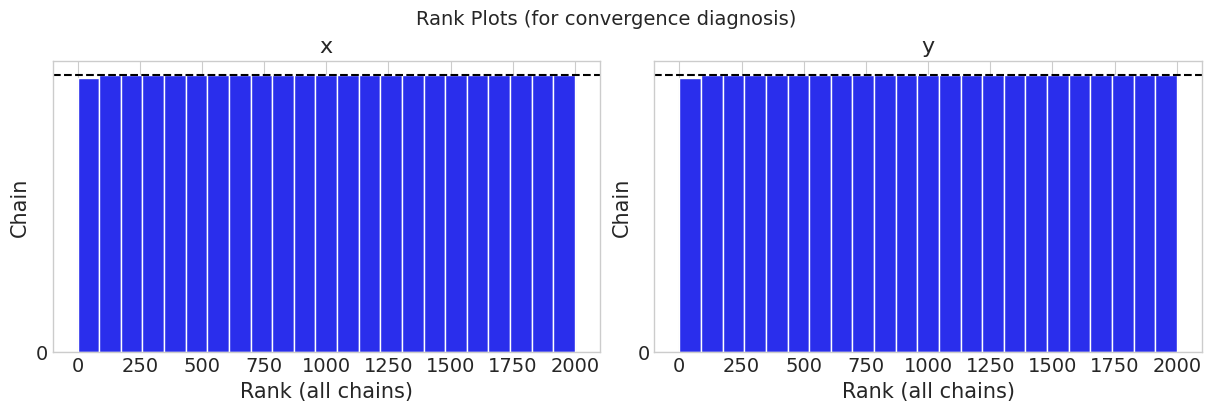


8. Effective Sample Size:
----------------------------------------
x: 1152
y: 1383


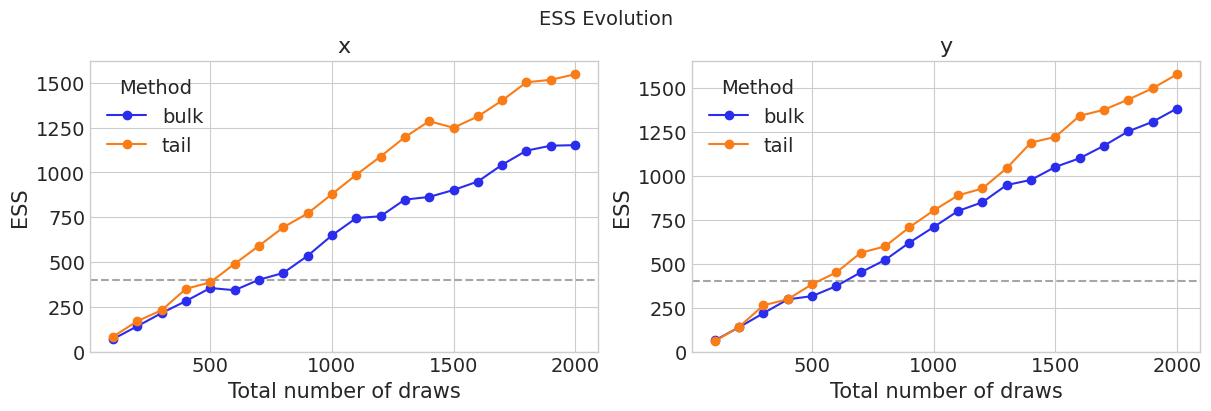


9. R-hat Statistics (should be < 1.01 for convergence):
----------------------------------------
x: nan
y: nan

10. Monte Carlo Standard Error:
----------------------------------------
x: 0.0407
y: 0.0330

11. Comparison with True Distribution:
----------------------------------------
True Mean:      [ 2. -1.]
Posterior Mean: [ 2.03739705 -0.95515679]
Mean Error:     [0.03739705 0.04484321]

True Covariance:
[[2.  0.8]
 [0.8 1.5]]

Posterior Covariance:
[[1.8983514  0.76186715]
 [0.76186715 1.50750297]]

Covariance Frobenius Error: 0.1153


In [128]:
# Run the full demo explicitly
# Tip: adjust CONFIG above before running.
idata = run_demo(CONFIG)

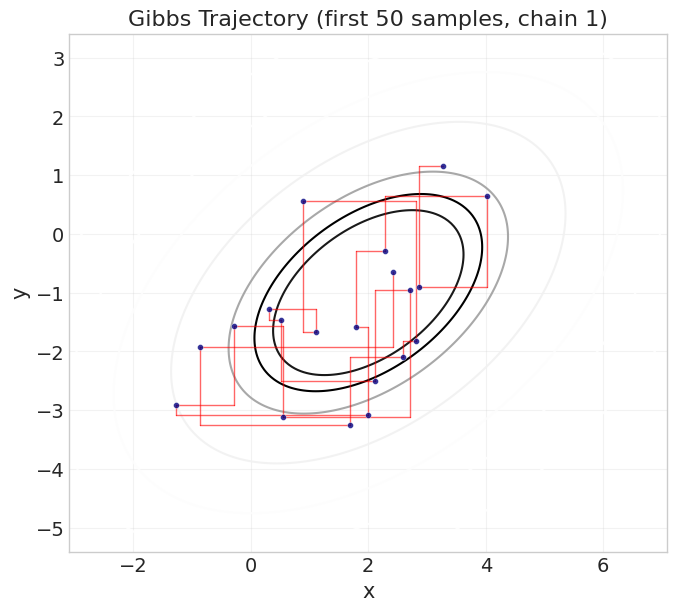

In [145]:
# Trajectory plot of the first 50 Gibbs samples (chain 1)
import numpy as np
from scipy.stats import multivariate_normal

# --- Extract samples ---
assert "idata" in globals(), "Run the cell that creates `idata` first."

n = 20
chain_idx = 0
x = idata.posterior["x"].values[chain_idx, :n]
y = idata.posterior["y"].values[chain_idx, :n]

# --- Set up contour background from the true MVN (if available) ---
true_mean = CONFIG.get("true_mean", np.array([0.0, 0.0]))
true_cov = CONFIG.get("true_cov", np.array([[1.0, 0.0], [0.0, 1.0]]))

# Determine plotting bounds using both true distribution and sample spread
sx = float(np.sqrt(true_cov[0, 0]))
sy = float(np.sqrt(true_cov[1, 1]))

x_min = min(true_mean[0] - 3 * sx, x.min())
x_max = max(true_mean[0] + 3 * sx, x.max())
y_min = min(true_mean[1] - 3 * sy, y.min())
y_max = max(true_mean[1] + 3 * sy, y.max())

# Add small margins
mx = 0.1 * (x_max - x_min + 1e-8)
my = 0.1 * (y_max - y_min + 1e-8)

x_grid = np.linspace(x_min - mx, x_max + mx, 200)
y_grid = np.linspace(y_min - my, y_max + my, 200)
X, Y = np.meshgrid(x_grid, y_grid)

rv = multivariate_normal(mean=true_mean, cov=true_cov)
Z = rv.pdf(np.dstack((X, Y)))

fig, ax = plt.subplots(figsize=(8, 6))

# Contours (grayscale, faint to strong)
levels = np.quantile(Z, [0.15, 0.3, 0.5, 0.7, 0.85, 0.93])
cs = ax.contour(X, Y, Z, levels=levels, cmap="Greys", alpha=0.9)
# Bold central contour for emphasis
ax.contour(X, Y, Z, levels=[np.quantile(Z, 0.9)], colors="k", linewidths=1.5)

# Axis-aligned Gibbs trajectory segments (horizontal then vertical)
for k in range(len(x) - 1):
    xk, yk = x[k], y[k]
    xk1, yk1 = x[k + 1], y[k + 1]
    # Horizontal move: (x_k, y_k) -> (x_{k+1}, y_k)
    ax.plot([xk, xk1], [yk, yk], color="red", alpha=0.6, linewidth=1)
    # Vertical move: (x_{k+1}, y_k) -> (x_{k+1}, y_{k+1})
    ax.plot([xk1, xk1], [yk, yk1], color="red", alpha=0.6, linewidth=1)

# Sample locations
ax.scatter(
    x, y, s=18, color="navy", alpha=0.8, zorder=3, edgecolors="white", linewidths=0.3
)

ax.set_title("Gibbs Trajectory (first 50 samples, chain 1)")
ax.set_xlabel(CONFIG.get("var_names", ("x", "y"))[0])
ax.set_ylabel(CONFIG.get("var_names", ("x", "y"))[1])
ax.grid(True, alpha=0.25)
ax.set_aspect("equal", adjustable="box")

plt.show()